##### План выполнения проекта   
1.[Запускаем библиотеки](#1);  
2.[Запускаем датасеты](#2);  
3.[Отвечаем на заданные вопросы](#3);   
      3.1 [Количество сделанных звонков и израсходованных минут разговора по месяцам](#3.1);    
      3.2 [Количество отправленных сообщений по месяцам](#3.2);    
      3.3 [Объем израсходованного интернет-трафика по месяцам](#3.3);    
      3.4 [Помесячную выручку с каждого пользователя](#3.4);    
4.[Описываем поведение клиентов оператора, исходя из выборки](#4);  
      4.1 [Считаем среднее количество, дисперсию и стандартное отклонение](#4.1);  
7 [Проверяем гипотезы](#5)      
8  [Общий вывод](#6)  

#### Шаг 1. Запускаем библиотеки <a id="1"></a>

In [3]:
#запускаем первым шагом все предполагаемые билиотеки, при необходимости в ходе проекта дополняем этот пункт
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from scipy import stats as st
from math import factorial

#### Шаг 2. Запускаем датасеты и изучаем общую информацию по ним <a id="2"></a>

In [5]:
calls = pd.read_csv('/content/calls.csv') 
internet = pd.read_csv('/content/internet.csv')
messages = pd.read_csv('/content/messages.csv')
tariffs = pd.read_csv('/content/tariffs.csv')
users = pd.read_csv('/content/users.csv')

In [6]:
calls.info() #просматриваем общую информацию по файлу
calls.duplicated().sum() #ищем дубликаты
calls.describe() #изучаем минимальные и максимальные значения, средние и квантили, ищем аномалии

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [7]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d') # меняем формат столбца
calls['duration'] = calls['duration'].astype('int64')

In [8]:
#высчитываем долю звонков, которые имеют продолжительность в 0 минут
calls_zero = calls.query('duration == 0')
share_zero = len(calls_zero) / len(calls)
share_zero

0.23655155053872767

In [9]:
calls.sample(n = 3, random_state = 1) 

,id,call_date,duration,user_id
26953,1066_374,2018-08-26,0,1066
66122,1168_1273,2018-03-28,16,1168
67325,1171_350,2018-09-14,6,1171


###### Наблюдение первое  
Данные достаточно чистые: не содержат дублей по строкам и уникальному столбцу - ID пользователя 
Продолжительность звонка может быть и 0 минут, когда 1 человек не дозвонился до другого, доля таковых в выборке 19.5%
Продолжительность звонка имеет выбросы, то есть все звонки более 10.7 минут продолжительностью уже редки. 


In [11]:
# изучаем базовую информацию по датасету
internet.info()
internet.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


0

In [12]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')  # меняем формат столбца

In [13]:
internet.drop('Unnamed: 0', axis='columns', inplace=True) #удаляем задублированный столбец
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [14]:
#высчитываем долю интернет сессий,в которые было скачано 0 Мб информации
internet_zero = internet.query('mb_used == 0')
share_zero_i= len(internet_zero) / len(internet)
share_zero_i

0.13118155773916304

In [15]:
internet.sample(n = 3, random_state = 1) 

,id,mb_used,session_date,user_id
35745,1124_125,122.45,2018-12-03,1124
18383,1064_102,320.60,2018-12-19,1064
59774,1203_22,605.96,2018-06-17,1203


###### Наблюдение второе 
В течении сессии может не быть израсходованного в мегабайтах трафика. Доля таковых заходов в инернет составляет 13.1%  
В среднем тратиться 370 Мб, рекордом же является 1724 Мб за одну сессию. 

In [16]:
# изучаем базовую информацию по датасету
messages.info()
messages.duplicated().sum()
messages.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d') # меняем формат столбца

In [18]:
messages.sample(n = 3, random_state = 1) 

,id,message_date,user_id
45696,1197_26,2018-12-31,1197
66091,1282_523,2018-11-30,1282
18743,1082_184,2018-10-18,1082


In [19]:
# изучаем базовую информацию по датасету
users.info()
users.duplicated().sum()
users.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [20]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d') # меняем форматы столбцов
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')

In [21]:
users.sample(n = 3, random_state = 1) 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
304,1304,68,NaT,Владимир,Илья,Соловьёв,2018-11-05,ultra
340,1340,50,NaT,Пенза,Тимофей,Алютин,2018-01-30,smart
47,1047,67,NaT,Саратов,Милица,Меркулова,2018-10-29,smart


In [22]:
# определяем кол-во пользователей, которые прекратили действование своего тарифа
share_churnD = users['churn_date'].count() / len(users) 
share_churnD

0.076

###### Наблюдение третье 
У нас имеются данные на все 500 пользователей, которые представлены и в других табликацах.  
Всего 7.6% позователей отказались от своего действующего тарифа, осталные же являются действующими. 

###### Считаем количество сделанных звонков и израсходованных минут разговора по месяцам <a id="3.1"></a>

In [64]:
calls['month'] = calls['call_date'].dt.month #создаем столбец с номером месяца
df_call = calls.pivot_table(index = 'month', values = 'duration', aggfunc =['sum', 'count']) #создаем сводную таблицу
df_call.columns = ['sum_duration', 'count_duration'] #меняем названия столбцом
df_call

,sum_duration,count_duration
month,,
1,9637,1476
2,21773,3328
3,42820,6687
4,58875,9272
5,78796,12647
6,93466,14716
7,117103,18298
8,136616,21488
9,154207,24061


Text(0.5, 0, 'Месяц')

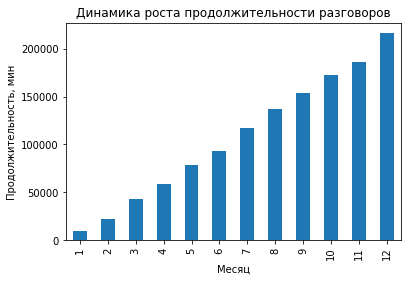

In [65]:
df_call['sum_duration'].plot( kind = 'bar') #создаем график
plt.title('Динамика роста продолжительности разговоров') #называем таблицу
plt.ylabel('Продолжительность, мин') #назовем сторону y
plt.xlabel('Месяц') #назовем сторону x

Text(0.5, 0, 'Месяц')

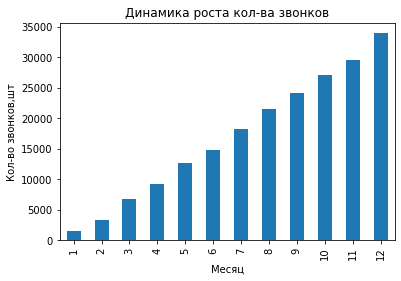

In [66]:
df_call['count_duration'].plot( kind = 'bar') #создаем график
plt.title('Динамика роста кол-ва звонков') #называем таблицу
plt.ylabel('Кол-во звонков,шт') #назовем сторону y
plt.xlabel('Месяц') #назовем сторону x

In [67]:
# определяем продолжительность звонка по месяцам
df_call['call_duration_per_user'] = df_call['sum_duration'] / df_call['count_duration'] #создаем новый столбец с продолжительностью звонка
df_call

,sum_duration,count_duration,call_duration_per_user
month,,,
1,9637,1476,6.529133
2,21773,3328,6.542368
3,42820,6687,6.403469
4,58875,9272,6.349763
5,78796,12647,6.230410
6,93466,14716,6.351318
7,117103,18298,6.399770
8,136616,21488,6.357781
9,154207,24061,6.409002


### Вывод  
На ежемесячной основе оператор увеличивает кол-во произведенных звонков его пользователями и тем самым увеличивается и суммарная продолжительность этих звонков. Параметры имеют прямую зависимость, однако всреднем один пользователь за год стал говорить на 2,5% меньше по времени, изменения произошли начиная с марта 2018 года.

 ###### Количество отправленных сообщений по месяцам   <a id="3.2"></a>

In [27]:
messages['month'] = messages['message_date'].dt.month #создаем столбец с номером месяца
df_messages = messages.pivot_table(index = 'month', values = 'id', aggfunc = 'count') #создаем сводную таблицу
df_messages.columns = ['number_of_messages'] #переназываем столбец
df_messages

,number_of_messages
month,
1,924
2,1924
3,3648
4,5179
5,7298
6,8983
7,11320
8,13088
9,14759


Text(0.5, 0, 'Месяц')

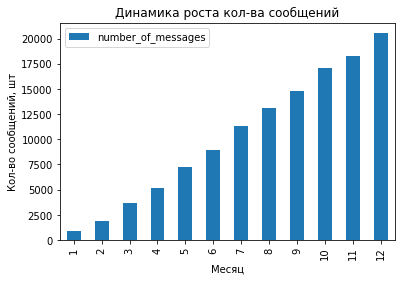

In [28]:
df_messages.plot( kind = 'bar')
plt.title('Динамика роста кол-ва сообщений')
plt.ylabel('Кол-во сообщений, шт') 
plt.xlabel('Месяц')

### Вывод

Кол-во отправленных сообщений растет из месяца в месяц: начиная от 924 в январе, заканчивая 20555 сообщений в декабре. При этом более чем двукратный рост был только в феврале месяце, после чего % прироста от месяца к месяцу уменьшался. 

###### Объем израсходованного интернет-трафика по месяцам  <a id="3.3"></a>

In [29]:
internet['month'] = internet['session_date'].dt.month #создаем столбец с номером месяца
df_internet = internet.pivot_table(index = 'month', values = 'mb_used', aggfunc = ['sum', 'count']) #создаем сводную таблицу
df_internet.columns = ['gb_used', 'session'] #переназываем столбцы
df_internet['gb_used'] = df_internet['gb_used'] / 1024 #переводим Мб в Гб для простоты усвоения данных
df_internet['gb_used'] =df_internet['gb_used'].astype('int')
df_internet

,gb_used,session
month,,
1,398,1117
2,932,2641
3,1769,4885
4,2376,6511
5,3443,9408
6,4082,11057
7,4911,13548
8,5857,16092
9,6296,17512


Text(0.5, 0, 'Месяц')

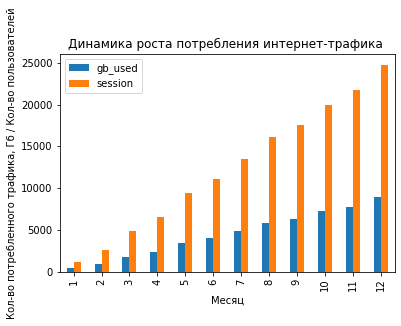

In [30]:
df_internet.plot( kind = 'bar')
plt.title('Динамика роста потребления интернет-трафика ')
plt.ylabel('Кол-во потребленного трафика, Гб / Кол-во пользователей') 
plt.xlabel('Месяц')

In [31]:
#определяем сколько Гб трафика потребляем 1 пользователь в месяц
df_internet['gb_per_users'] = df_internet['gb_used'] / df_internet['session']
df_internet   

,gb_used,session,gb_per_users
month,,,
1,398,1117,0.356312
2,932,2641,0.352897
3,1769,4885,0.362129
4,2376,6511,0.364921
5,3443,9408,0.365965
6,4082,11057,0.369178
7,4911,13548,0.362489
8,5857,16092,0.363970
9,6296,17512,0.359525


In [32]:
# определяем сессии, в которые не был потрачен трафик по тарифу
iwz = internet.query('mb_used == 0') 
iwz_month = iwz.pivot_table(index = 'month', values = 'mb_used', aggfunc = 'count')
iwz_month.columns = ['count_zero_mb'] #переназываем столбец
share_zero = df_internet.merge(iwz_month, on = 'month') #соединяем 2 таблицы через столбец с номером месяца
share_zero['share_zero'] = share_zero['count_zero_mb'] / share_zero['session']
share_zero

,gb_used,session,gb_per_users,count_zero_mb,share_zero
month,,,,,
1,398,1117,0.356312,151,0.135184
2,932,2641,0.352897,378,0.143128
3,1769,4885,0.362129,623,0.127533
4,2376,6511,0.364921,819,0.125787
5,3443,9408,0.365965,1199,0.127445
6,4082,11057,0.369178,1401,0.126707
7,4911,13548,0.362489,1760,0.129908
8,5857,16092,0.363970,2083,0.129443
9,6296,17512,0.359525,2314,0.132138


### Вывод

На ежемесячной основе увеличивается кол-во потребленных Гб интернет-трафика пользователями за счет прироста в новых клиентах.   Двукратный рост от месяца к месяцу показали февраль и март, также значительный прирост произашел в декабре 2018 года, когда значения потребленного трафика достигли 8 919 Гб. При этом на ежемесячной основе растет и кол-во клиентов, которые не используют интернет в течении месяца, однако их доля остается практически неизменной в течении года (13%)

### Определяем помесячную выручку с каждого пользователя   <a id="3.4"></a>

In [33]:
#создаем сводные таблицы и сбрасываем в них мультииндекс
df_call_per_user = calls.pivot_table(index = ['month', 'user_id'], values = 'duration', aggfunc =['sum', 'count']).reset_index()
df_messages_per_user = messages.pivot_table(index = ['month', 'user_id'], values = 'id', aggfunc = 'count').reset_index()
df_internet_per_user = internet.pivot_table(index = ['month', 'user_id'], values = 'mb_used', aggfunc = 'sum').reset_index()
df_call_per_user.columns = ['month', 'user_id', 'sum_duration', 'count_duration']
df_messages_per_user.columns = ['month', 'user_id', 'id_messages']

In [34]:
#ведем последовательное объединение таблиц с переименовываем столбцов
full_one = df_call_per_user.merge(df_messages_per_user, on = ['user_id', 'month'], how = 'outer')
full_one
full_one.columns = ['month', 'user_id','sum_duration', 'count_duration', 'count_messages']
full_one

full_two = full_one.merge(df_internet_per_user, on = ['user_id', 'month'], how = 'outer')
full_two = full_two.fillna(0)
full_two

full_three = full_two.merge(users, on = 'user_id', how = 'left')
full_three

,month,user_id,sum_duration,count_duration,count_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1,1005,84.0,15.0,7.0,2727.97,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
1,1,1032,338.0,61.0,38.0,24127.69,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart
2,1,1045,8.0,1.0,5.0,2346.71,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart
3,1,1055,505.0,64.0,30.0,17090.88,39,NaT,Казань,Луиза,Березина,2018-01-02,smart
4,1,1071,176.0,24.0,16.0,15604.34,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1231,0.0,0.0,191.0,32448.00,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra
3210,12,1328,0.0,0.0,7.0,39419.73,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra
3211,12,1473,0.0,0.0,20.0,18418.26,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra
3212,12,1489,0.0,0.0,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


In [35]:
#переименовываем название столбца для возможности объединения датасетов
tariffs.rename(columns={'tariff_name':'tariff'}, inplace = True)

In [36]:
#продолжаем вести последовательное объединение таблиц с переименовываем столбцов
user_data = full_three.merge(tariffs, on = 'tariff', how = 'outer')
user_data.rename(columns={'mb_used':'gb_used'}, inplace = True)
user_data['gb_used'] = user_data['gb_used'] / 1024
user_data.rename(columns={'mb_per_month_included':'gb_per_month_included'}, inplace = True)
user_data['gb_per_month_included'] = user_data['gb_per_month_included'] / 1024
user_data['gb_used'] =user_data['gb_used'].astype('int')

user_data

,month,user_id,sum_duration,count_duration,count_messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1,1005,84.0,15.0,7.0,2,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15.0,500,550,200,3,3
1,1,1032,338.0,61.0,38.0,23,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,50,15.0,500,550,200,3,3
2,1,1045,8.0,1.0,5.0,2,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,50,15.0,500,550,200,3,3
3,1,1055,505.0,64.0,30.0,16,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,50,15.0,500,550,200,3,3
4,1,1071,176.0,24.0,16.0,15,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,50,15.0,500,550,200,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1106,0.0,0.0,24.0,18,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,1000,30.0,3000,1950,150,1,1
3210,12,1231,0.0,0.0,191.0,31,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,1000,30.0,3000,1950,150,1,1
3211,12,1328,0.0,0.0,7.0,38,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,1000,30.0,3000,1950,150,1,1
3212,12,1473,0.0,0.0,20.0,17,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30.0,3000,1950,150,1,1


In [37]:
#создаем цикл через который определяем перерасход по каждому пользователю по месяцам
def monthly_revenue(row):
    calls2 = row['sum_duration']
    messeges2 = row['count_messages']
    internet2 = row['gb_used']
    
    calls2 = (row['sum_duration'] - row['minutes_included']) * row ['rub_per_minute']
    messeges2 = (row['count_messages'] - row['messages_included']) * row ['rub_per_message']
    internet2 = (row['gb_used'] - row['gb_per_month_included']) * row ['rub_per_gb']
    
    over_limits = 0
    
    for x in [calls2, messeges2, internet2]:
        if x > 0:
            over_limits += x
    return over_limits

user_data['over_limit'] = user_data.apply(monthly_revenue, axis  = 1)

In [38]:
#создаем столбец с выручкой на 1 пользователя за месяц
user_data['income_per_user'] = user_data['rub_monthly_fee'] + user_data['over_limit']
user_data

,month,user_id,sum_duration,count_duration,count_messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_limit,income_per_user
0,1,1005,84.0,15.0,7.0,2,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15.0,500,550,200,3,3,0.0,550.0
1,1,1032,338.0,61.0,38.0,23,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,50,15.0,500,550,200,3,3,1600.0,2150.0
2,1,1045,8.0,1.0,5.0,2,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,50,15.0,500,550,200,3,3,0.0,550.0
3,1,1055,505.0,64.0,30.0,16,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,50,15.0,500,550,200,3,3,215.0,765.0
4,1,1071,176.0,24.0,16.0,15,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,50,15.0,500,550,200,3,3,0.0,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1106,0.0,0.0,24.0,18,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
3210,12,1231,0.0,0.0,191.0,31,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,1000,30.0,3000,1950,150,1,1,150.0,2100.0
3211,12,1328,0.0,0.0,7.0,38,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,1000,30.0,3000,1950,150,1,1,1200.0,3150.0
3212,12,1473,0.0,0.0,20.0,17,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0


In [39]:
#изучаем суммы перерасхода по тарифам и по месяцам
mean_income_per_user = user_data.pivot_table(index = 'month',columns = "tariff", values = ['income_per_user', 'over_limit'], aggfunc = 'mean')
mean_income_per_user.columns = ['income_per_user_smart', 'income_per_user_ultra', 'over_limit_smart', 'over_limit_ultra']
mean_income_per_user = mean_income_per_user.reset_index()
mean_income_per_userr = mean_income_per_user.round()
mean_income_per_userr

,month,income_per_user_smart,income_per_user_ultra,over_limit_smart,over_limit_ultra
0,1,676.0,1950.0,126.0,0.0
1,2,749.0,1962.0,199.0,12.0
2,3,1008.0,1995.0,458.0,45.0
3,4,841.0,1988.0,291.0,38.0
4,5,1042.0,2046.0,492.0,96.0
5,6,1044.0,2023.0,494.0,73.0
6,7,1059.0,2095.0,509.0,145.0
7,8,1138.0,2059.0,588.0,109.0
8,9,1074.0,2006.0,524.0,56.0
9,10,1181.0,2045.0,631.0,95.0


Text(0.5, 0, 'Месяц')

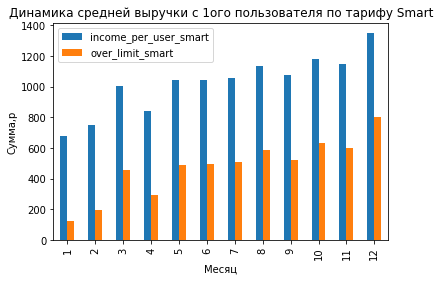

In [40]:
#отображаем на графике общую сумму по месяцам в тарифе Smart
mean_income_per_userr.plot(kind = 'bar', x = 'month', y = ['income_per_user_smart', 'over_limit_smart'])
plt.title('Динамика средней выручки с 1ого пользователя по тарифу Smart')
plt.ylabel('Сумма,р') #назовем сторону y
plt.xlabel('Месяц')

Text(0.5, 0, 'Месяц')

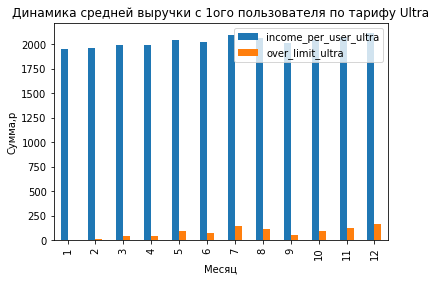

In [41]:
#отображаем на графике общую сумму по месяцам в тарифе Ultra
mean_income_per_userr.plot(kind = 'bar', x = 'month', y = ['income_per_user_ultra', 'over_limit_ultra'])
plt.title('Динамика средней выручки с 1ого пользователя по тарифу Ultra')
plt.ylabel('Сумма,р') #назовем сторону y
plt.xlabel('Месяц')

### Вывод

Средняя выручка с одного пользователя за месяц выросла за год с 961р до 1622р. При любом тарифе у клиентов есть перерасход, который достигает свеого пика в декабре.   
При этом выручка с одного пользователя по тарифу Smart выросла с 676 до 1351р за год, а перерасход в декабре составил 801р, что больше суммы ежемесячного платежа на 251р! Есть высокие риски того,что клиенты с данного тарифа могут уйти к конкурентам, так как базовый тариф не покрывает все их потребности.   
Выручка с одного пользователя по тарифу Ultra выросла с 1950р до 2113р, а перерасход в декабре составил всего 163р, что составляет всего 8% от суммы базового тарифа.

### Шаг 3 Описываем поведение клиентов оператора, исходя из выборки  <a id="4"></a>

In [42]:
#опредляем помесячное кол-во пользователей по тарифам
client = user_data.pivot_table(index = 'month', columns = 'tariff', values = 'rub_monthly_fee', aggfunc = ['count'])
client.columns = ['smart', 'ultra']
client

,smart,ultra
month,,
1,34,9
2,58,24
3,77,37
4,112,55
5,141,67
6,164,84
7,201,91
8,235,107
9,260,115


Text(0.5, 0, 'Месяц')

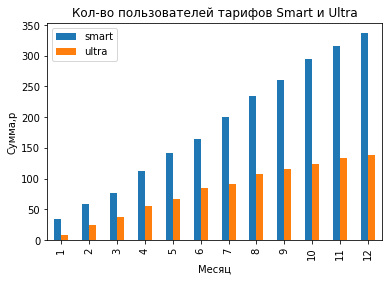

In [43]:
client.plot( kind = 'bar')
plt.title('Кол-во пользователей тарифов Smart и Ultra')
plt.ylabel('Сумма,р') #назовем сторону y
plt.xlabel('Месяц')

##### Наблюдение четвертое  
2229 клиентов выбрали Тариф 'Smart' за год, а тариф 'Ultra' - 985, что объяснимо их разницей в цене и объеме предосавлямых возможностей. Оба тарифа десмонтрировали рост от месяца к месяцу.

In [44]:
# Определяем долю тарифа Ultra относительно Smart
delta = user_data.pivot_table(index = 'month', columns = 'tariff', values = 'rub_monthly_fee', aggfunc = ['count'])
delta.columns = ['smart', 'ultra']
delta['share'] = delta['ultra'] / (delta['smart'] + delta['ultra']) *100
delta_share = delta['share']
delta_share.mean()
delta_share

month
1     20.930233
2     29.268293
3     32.456140
4     32.934132
5     32.211538
6     33.870968
7     31.164384
8     31.286550
9     30.666667
10    29.496403
11    29.777778
12    29.201681
Name: share, dtype: float64

Text(0.5, 0, 'Месяц')

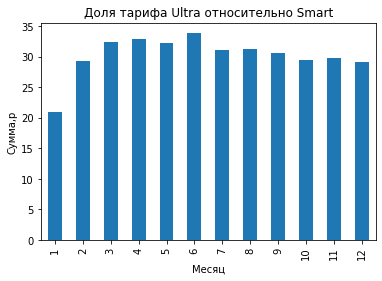

In [45]:
delta_share.plot( kind = 'bar')
plt.title('Доля тарифа Ultra относительно Smart')
plt.ylabel('Сумма,р') #назовем сторону y
plt.xlabel('Месяц')

##### Наблюдение пятое   
Доля тарифа Ultra относительно тарифа Smart по году составляет 30%. Наибольший скачек произашел в феврале 2018 года, и начиная со второй половины года кол-во людей, подключивших себе Smart росло немного быстрее в сранении с теми, кто подключал себе Ultra. 

In [46]:
#определяем кол-во пользователей, которые имеют перерасход по месяцам в тарифе Smart
mean_income_per_userr['share_over_limit'] = mean_income_per_userr['over_limit_smart'] / mean_income_per_userr['income_per_user_smart'] * 100
share_over_limit = mean_income_per_userr['share_over_limit']
share_over_limit

0     18.639053
1     26.568758
2     45.436508
3     34.601665
4     47.216891
5     47.318008
6     48.064212
7     51.669596
8     48.789572
9     53.429297
10    52.215465
11    59.289415
Name: share_over_limit, dtype: float64

In [47]:
#определяем кол-во пользователей, которые имеют перерасход по итогу года в тарифе Smart
over_limit_smart = mean_income_per_userr['over_limit_smart'].sum() / mean_income_per_userr['income_per_user_smart'].sum()
over_limit_smart

0.4640246873477343

Text(0.5, 0, 'Месяц')

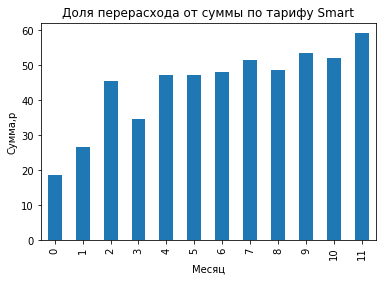

In [48]:
share_over_limit.plot( kind = 'bar')
plt.title('Доля перерасхода от суммы по тарифу Smart')
plt.ylabel('Сумма,р') #назовем сторону y
plt.xlabel('Месяц')

##### Наблюдение шестое   
46.4% пользователей тарифа Smart доплачивают к базовой ежемесячной сумме, при этом от декабря к январю эта доля выросла с 18.6% до 59.3%

In [49]:
#исследуем пользователей, которые отказались от своего тарифа
user_data['churn_date'] = pd.to_datetime(user_data['churn_date'], format = '%Y-%m-%d') #меняем формат столбца

In [50]:
user_data['month_churn'] = user_data['churn_date'].dt.month

In [51]:
#опреляем по месяцам кол-во пользователей, которые отписались от своего тарифа
user_data_churn = user_data.pivot_table(index = 'month_churn', columns = 'tariff', values = 'user_id', aggfunc = 'count')
user_data_churn

tariff,smart,ultra
month_churn,,
8.0,8,8
9.0,8,16
10.0,31,19
11.0,27,8
12.0,37,25


Text(0.5, 0, 'Месяц')

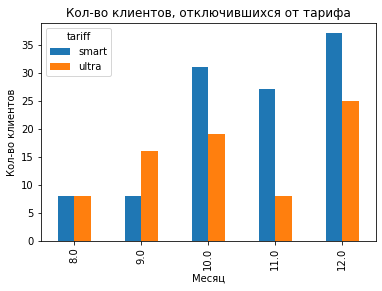

In [52]:
user_data_churn.plot( kind = 'bar')
plt.title('Кол-во клиентов, отключившихся от тарифа')
plt.ylabel('Кол-во клиентов') #назовем сторону y
plt.xlabel('Месяц')

##### Наблюдение седьмое  
За 2018 год отлючились от тараифов Smart и Ultra 187 клиентов, из которых от тарифа Smart отказались 111ч, что составило 5% от всех пользователей тарифа и 76ч - от тарифа Ultra, что составило 7,7%. Первые отключения начались в августе 2018 года, четкой динамики по месяцам отключения нет.  

In [53]:
#опреляем срок использования тарифа
user_data['month_churn'] = pd.to_datetime(user_data['month_churn'], format = '%Y-%m-%d')
user_data['month_churn'] = user_data['month_churn'].dt.day
user_data['delta'] = user_data['month'] - user_data['month_churn']

churn = user_data.pivot_table(index = 'delta', columns = 'tariff', values = 'user_id', aggfunc = 'count')
churn.columns = ['smart_churn', 'ultra_churn']  
churn['smart_churn'].median()
churn['ultra_churn'].median()
churn

,smart_churn,ultra_churn
delta,,
0.0,1,1
1.0,3,3
2.0,5,3
3.0,7,4
4.0,8,5
5.0,9,7
6.0,12,9
7.0,13,11
8.0,13,11


Text(0.5, 0, 'Кол-во месяцев использования тарифа')

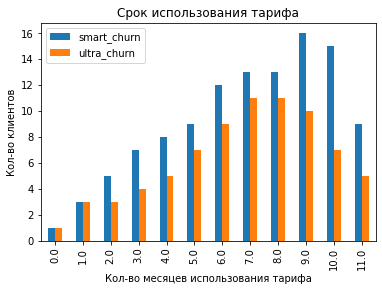

In [54]:
churn.plot( kind = 'bar')
plt.title('Срок использования тарифа')
plt.ylabel('Кол-во клиентов') #назовем сторону y
plt.xlabel('Кол-во месяцев использования тарифа')

##### Наблюдение восьмое  
С ростом периода использования тарифа растет и кол-во отключившихся от него. В первый - второй месяц использования кол-во отключенных от тарифов равно и составляет менее 2% процентов от общего кол-во отлючившихся.
Наибольшее кол-во клиентов, использующих тариф Smart отлючаются от него на 9-10 месяце использования, а на тарифе Ultra на 7-8 месяце. <a id="4.1"></a>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


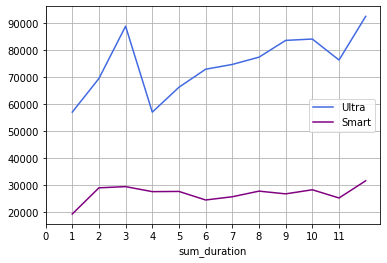

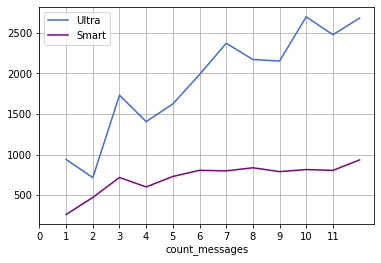

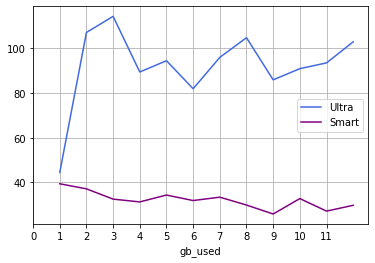

In [55]:
# Считаем среднее количество, дисперсию и стандартное отклонение.
df_total_var = user_data.groupby(by=['tariff','month'])['sum_duration', 'count_messages', 'gb_used'].var().reset_index() #группируем данные для формирования графиков с дисперсией по месяцам
columns_name = {'sum_duration', 'count_messages', 'gb_used'}
for column in columns_name: #создаем цикл для формирования сразу 3х графиков
    ax = df_total_var.query('tariff == "ultra"').plot(x='month', y = column, color='royalblue', label='Ultra', legend=True, grid = True)
    df_total_var.query('tariff == "smart"').plot(x='month', y = column, color='purple', label='Smart', ax=ax, legend=True, grid = True)
    plt.xlabel(column)
    plt.xticks(np.arange (0, 12, step=1.0))
    plt.show()

In [56]:
df_total_var

,tariff,month,sum_duration,count_messages,gb_used
0,smart,1,19287.850267,262.367201,39.412656
1,smart,2,28999.793406,473.097701,37.150938
2,smart,3,29448.392344,718.492481,32.549897
3,smart,4,27586.573681,602.139559,31.299550
4,smart,5,27663.360486,730.990983,34.370010
5,smart,6,24492.664485,806.806374,31.911716
6,smart,7,25688.934776,799.887811,33.419453
7,smart,8,27775.455974,838.257501,29.902419
8,smart,9,26762.382225,790.617820,25.884110
9,smart,10,28281.329305,816.111966,32.785215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


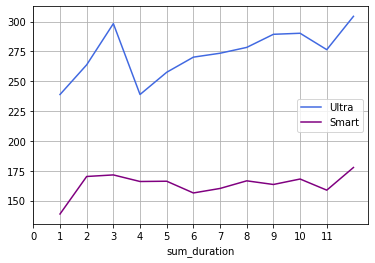

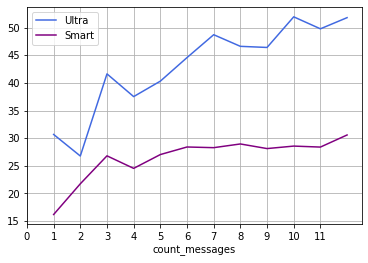

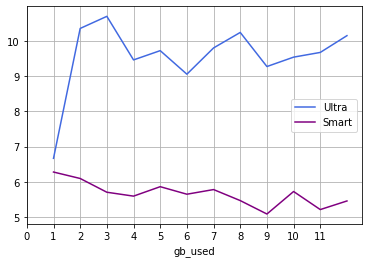

In [57]:
#опредялем стандартное отклонение тем же методом
df_total_std = user_data.groupby(by=['tariff','month'])['sum_duration', 'count_messages', 'gb_used'].std().reset_index()
columns_name = {'sum_duration', 'count_messages', 'gb_used'}
for column in columns_name:
    ax = df_total_std.query('tariff == "ultra"').plot(x='month', y = column, color='royalblue', label='Ultra', legend=True, grid = True)
    df_total_std.query('tariff == "smart"').plot(x='month', y = column, color='purple', label='Smart', ax=ax, legend=True, grid = True)
    plt.xlabel(column)
    plt.xticks(np.arange (0, 12, step=1.0))
    plt.show()

### Вывод

Графики со стандратным отклонением и дисперсией аналогичны друг другу.  
В целом видно, что в тарифе Smart дисперсия довольно постоянна, а вот в тарифе Ultra она скачет от месяца к месяцу и увеличивается. То есть пользователь от месяца к месяцу ведут себя слегка по разному. Их разброс отличается. Что касается пользователей Smart, то в целом от месяца к месяцу их распределение предсказуемо

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


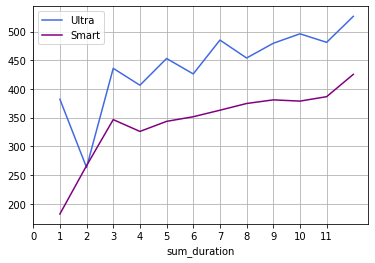

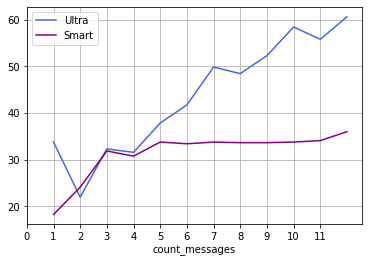

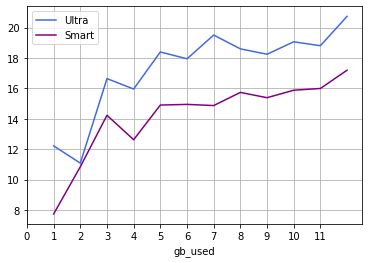

In [58]:
#опредялем среднее значение тем же методом
df_total_mean = user_data.groupby(by=['tariff','month'])['sum_duration', 'count_messages', 'gb_used'].mean().reset_index()
columns_name = {'sum_duration', 'count_messages', 'gb_used'}
for column in columns_name:
    ax = df_total_mean.query('tariff == "ultra"').plot(x='month', y = column, color='royalblue', label='Ultra', legend=True, grid = True)
    df_total_mean.query('tariff == "smart"').plot(x='month', y = column, color='purple', label='Smart', ax=ax, legend=True, grid = True)
    plt.xlabel(column)
    plt.xticks(np.arange (0, 12, step=1.0))
    plt.show()

### Вывод

В течении года прослеживается тренд на увеличение кол-ва абонентов и как следствие увеличения потребляемых услуг. При этом резко спрос увеличивается в декабре.

##### Шаг 4. Проверяем Гипотезу - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается <a id="5"></a>

Нулевая гипотеза - Средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ различается.  
Альтернативная гипотеза - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.   


In [59]:
# Проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
# для нулевой гипотезы среднее равно {не отличается}, а для альтернативной наоборот не равно {отличается}
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(user_data.query('tariff == "smart"')['income_per_user'],user_data.query('tariff == "ultra"')['income_per_user'], equal_var = False)
# выбран параметр equal_var = False, так как дисперсии выборок не равны, что видно в графиках выше
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.0
Отвергаем нулевую гипотезу


##### Вывод  
Выручка тарифов значительно отличается.

###### Проверяем Гипотезу - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза - Средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов  
Альтернативаная гипотеза - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [60]:
# Проверить вторую гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
results_city = st.ttest_ind(user_data.query('city == "Москва"')['income_per_user'],user_data.query('city != "Москва"')['income_per_user'], equal_var = False)
# выбран параметр equal_var = False, так как дисперсии выборок не равны, что видно в графиках выше
print('p-значение: ', results_city.pvalue)

if results_city.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.2869683109498313
Не получилось отвергнуть нулевую гипотезу


##### Вывод  

Выручка пользователей из других регионов в сравнении с Москвой отличается не значительно. 

In [61]:
user_data

,month,user_id,sum_duration,count_duration,count_messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_limit,income_per_user,month_churn,delta
0,1,1005,84.0,15.0,7.0,2,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15.0,500,550,200,3,3,0.0,550.0,NaN,NaN
1,1,1032,338.0,61.0,38.0,23,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,50,15.0,500,550,200,3,3,1600.0,2150.0,NaN,NaN
2,1,1045,8.0,1.0,5.0,2,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,50,15.0,500,550,200,3,3,0.0,550.0,NaN,NaN
3,1,1055,505.0,64.0,30.0,16,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,50,15.0,500,550,200,3,3,215.0,765.0,NaN,NaN
4,1,1071,176.0,24.0,16.0,15,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,50,15.0,500,550,200,3,3,0.0,550.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1106,0.0,0.0,24.0,18,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0,NaN,NaN
3210,12,1231,0.0,0.0,191.0,31,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,1000,30.0,3000,1950,150,1,1,150.0,2100.0,NaN,NaN
3211,12,1328,0.0,0.0,7.0,38,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,1000,30.0,3000,1950,150,1,1,1200.0,3150.0,NaN,NaN
3212,12,1473,0.0,0.0,20.0,17,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0,NaN,NaN


In [62]:
smart = user_data.query('tariff == "smart"')
smart['income_per_user'].sum()

2482035.0

In [63]:
ultra = user_data.query('tariff == "ultra"')
ultra['income_per_user'].sum()

2019000.0

# Общий вывод  <a id="6"></a>
В моменте по окончанию 2018 года для компании Мегалайн, тариф Smart принес компании большую выручку на примерно 460 тысяч рублей в сравнении с тарифом Ultra. А значит более выгодный с точки зрения товарооборота. Кроме того, ользователи тарифа Smart более стабильны в своих затратах из месяца в месяц.

Однако, стоит также учесть и ряд других фактов:  
1. Кол-во пользователей тарифа Smart в 3 раза больше, а значит имеется и больше затрат на их обслуживание. Здесь требуется дополнительное исследование.
2. 46.4% пользователи тарифа Smart доплачивают сверх своего базового тарифа. Средняя сумма доплаты составляет 1213р
3. Нет информации по причинам ухода с тарифом, коих на тарифе Smart 11%, а на тарифе Ultra 18%. Здесь требуется дополнительное исследование. В кол-ве пользователей, с тарифа Smart уходит больше людей в 1,5 раза относительно Ultra.
4. Нет информации о стоимости привлечения одного пользователя на разные тарифы. Здесь также требуется дополнительное исследование.

Рекомендация:  
1) Провести исследования затрат по каждому тарифу для оценки их эффективности.  
2) Создать третий вариант тарифа - средний по значениям между Smart и Ultra с целью сегментирования пользователей тарифа Smart. Данное предложение возможно позволит сократить кол-во ушедших пользователей с текущих тарифом, а значит и снизить издержки на рекламу и заведение нового пользователя. 